Begin by importing the libraries needed for data cleaning and preparation.

In [1]:
import numpy as np
import pandas as pd

The next step is to read in the first dataset of interest, ADMISSIONS, and have a first look at the columns and rows. <br> 
This dataset was obtained from the MIMIC III database (https://mimic.physionet.org/).

In [2]:
admissions = pd.read_csv('ADMISSIONS.csv.gz', compression='gzip')
print(admissions.shape)
admissions.head(2)

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1


There are 58976 rows and 19 columns.

#### Columns of interest (or may be of interest) from the 'admissions' dataset include:
- HOSPITAL_EXPIRE_FLAG
- SUBJECT_ID
- HADM_ID
- ADMITTIME
- DEATHTIME
- ADMISSION_TYPE

In [3]:
# exploring the data to determine the datatypes, in particular, of the date columns.
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

Next, convert the dates to datetime format for processing.

In [4]:
#convert ADMITTIME and DEATHTIME to datetime format. The errors='coerce' argument allows for missing values
admissions.ADMITTIME = pd.to_datetime(admissions.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions.DEATHTIME = pd.to_datetime(admissions.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

# check to see if there are any null dates
print('Number of missing date admissions:', admissions.ADMITTIME.isnull().sum())
print('Number of missing DEATHTIME:', admissions.DEATHTIME.isnull().sum())


Number of missing date admissions: 0
Number of missing DEATHTIME: 53122


In [5]:
# The next step is to add the target variable 'DEATH' which indicates whether or not a hospitalization resulted in death.
# positive death=1/negative death=0

#admissions['DEATH'] = admissions['DEATHTIME']>pd.Timestamp('00:00:00')
#admissions.DEATH.value_counts()
#print(admissions.DEATH.value_counts())
#print(admissions.DEATH.shape)

In [6]:
# I later realized that the column "HOSPITAL_EXPIRE_FLAG" is same as the "DEATH" column that was created.
# drop DEATH column
#admissions.drop('DEATH', axis=1, inplace=True)
#admissions.columns


In [7]:
admissions.HOSPITAL_EXPIRE_FLAG.value_counts()

0    53122
1     5854
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

5,854 out of 58,976 hospital admissions resulted in death (roughly 10%). Therefore, the dataset is imbalanced.

The 'admissions' dataframe is ready to go! <br>
<br>
Next: Read in the caregiver notes dataset and get an overview of its rows and features.


In [8]:
#Read in the caregiver notes dataset.

notes = pd.read_csv('NOTEEVENTS.csv.gz', compression='gzip', low_memory=False)
notes.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...


Columns of interest from the NOTES dataset:
- SUBJECT_ID
- HADM_ID
- NOTES
- CHARTDATE and CHARTTIME
- CATEGORY
- TEXT

In [9]:
notes.shape

(2083180, 11)

In [10]:
# Viewing categories of caregiver notes to better understand the dataset.
notes.CATEGORY.value_counts()


Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: CATEGORY, dtype: int64

In [11]:
notes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB


CHARTDATE records the date at which the note was charted. CHARTDATE will always have a time value of 00:00:00.

CHARTTIME records the date and time at which the note was charted. If both CHARTDATE and CHARTTIME exist, then the date portions will be identical. All records have a CHARTDATE. A subset are missing CHARTTIME. More specifically, notes with a CATEGORY value of ‘Discharge Summary’, ‘ECG’, and ‘Echo’ never have a CHARTTIME, only CHARTDATE. Other categories almost always have both CHARTTIME and CHARTDATE, but there is a small amount of missing data for CHARTTIME (usually less than 0.5% of the total number of notes for that category).

In [12]:
#convert the chart dates and times into datetime format

notes.CHARTTIME = pd.to_datetime(notes.CHARTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
notes.CHARTDATE = pd.to_datetime(notes.CHARTDATE, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')


# check to see if there are any null dates
print('Number of missing CHARTTIME:', notes.CHARTTIME.isnull().sum())
print('Number of missing CHARTDATE:', notes.CHARTDATE.isnull().sum())



Number of missing CHARTTIME: 316566
Number of missing CHARTDATE: 0


Since there are so many missing CHARTTIME values, CHARTDATE will be used for processing and analysis (see below). Before analyzing further, the dataframes will be merged.

In [13]:
# Merging the 'admissions' and 'notes' together. A left merge is used so that all rows for hospital admissions are included
# and any caregiver notes that are not associated with a hospital admission are dropped.
df=pd.merge(admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'HOSPITAL_EXPIRE_FLAG', 'ADMISSION_TYPE', 'DEATHTIME']],\
            notes[['SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CATEGORY','TEXT']], \
            on=('HADM_ID','SUBJECT_ID') , how='left', suffixes=('adm','note'))
print('There are ', len(df), 'rows and ',len(df.columns), 'columns.')


There are  1851959 rows and  9 columns.


In [14]:
list(df.columns)

['SUBJECT_ID',
 'HADM_ID',
 'ADMITTIME',
 'HOSPITAL_EXPIRE_FLAG',
 'ADMISSION_TYPE',
 'DEATHTIME',
 'CHARTDATE',
 'CATEGORY',
 'TEXT']

Next a new column ENDTIME will be created. This will indicate the when to end note collection for analysis - i.e., 24 hours after ADMITTIME or at time of death - whichever is sooner.


In [15]:
df['ADMIT+24'] = df['ADMITTIME'] + pd.DateOffset(1)
df['ENDTIME'] = df['ADMIT+24']

df.ENDTIME = np.where(df['DEATHTIME'] < df['ENDTIME'], df['DEATHTIME'], df['ENDTIME'])
df.head(20)

,SUBJECT_ID,HADM_ID,ADMITTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,DEATHTIME,CHARTDATE,CATEGORY,TEXT,ADMIT+24,ENDTIME
0,22,165315,2196-04-09 12:26:00,0,EMERGENCY,NaT,2196-04-10,Discharge summary,Admission Date: [**2196-4-9**] Discharg...,2196-04-10 12:26:00,2196-04-10 12:26:00
1,22,165315,2196-04-09 12:26:00,0,EMERGENCY,NaT,2196-04-09,ECG,Normal sinus rhythm. Non-diagnostic repolariza...,2196-04-10 12:26:00,2196-04-10 12:26:00
2,22,165315,2196-04-09 12:26:00,0,EMERGENCY,NaT,2196-04-09,ECG,Normal sinus rhythm without diagnostic abnorma...,2196-04-10 12:26:00,2196-04-10 12:26:00
3,22,165315,2196-04-09 12:26:00,0,EMERGENCY,NaT,2196-04-10,Radiology,[**2196-4-10**] 11:52 PM\n CHEST (PORTABLE AP)...,2196-04-10 12:26:00,2196-04-10 12:26:00
4,22,165315,2196-04-09 12:26:00,0,EMERGENCY,NaT,2196-04-09,Radiology,[**2196-4-9**] 10:19 AM\n CT HEAD W/O CONTRAST...,2196-04-10 12:26:00,2196-04-10 12:26:00
5,22,165315,2196-04-09 12:26:00,0,EMERGENCY,NaT,2196-04-09,Radiology,[**2196-4-9**] 10:40 AM\n CHEST (PORTABLE AP) ...,2196-04-10 12:26:00,2196-04-10 12:26:00
6,22,165315,2196-04-09 12:26:00,0,EMERGENCY,NaT,2196-04-09,Nursing/other,MICU/SICU NURSING ADMISSION NOTE\n Admitte...,2196-04-10 12:26:00,2196-04-10 12:26:00
7,22,165315,2196-04-09 12:26:00,0,EMERGENCY,NaT,2196-04-09,Nursing/other,Resp Care\npt received from eu s/p intubation ...,2196-04-10 12:26:00,2196-04-10 12:26:00
8,22,165315,2196-04-09 12:26:00,0,EMERGENCY,NaT,2196-04-10,Nursing/other,S/MICU Nursing Progress Note\nPt extubated at ...,2196-04-10 12:26:00,2196-04-10 12:26:00
9,22,165315,2196-04-09 12:26:00,0,EMERGENCY,NaT,2196-04-10,Nursing/other,PT TRANSFER NOTE PLEASE REFER TO ADMIT NOTE [*...,2196-04-10 12:26:00,2196-04-10 12:26:00


In [16]:
#update dataframe to only include notes taken within 24 hours of admission

df2 = df[df['CHARTDATE'] <= df['ENDTIME']]

In [17]:
df2.shape

(444799, 11)

In [18]:
#Saving the merged dataframe.
df2.to_csv('df2.csv', index=False)

#### If restarting code, start with line below to begin with merged dataframe

In [19]:
import pandas as pd
import numpy
df2 = pd.read_csv('df2.csv')

In [20]:
#find out which samples died before admission and remove them from the dataframe. Save as new dataframe.
df3 = df2.loc[df2['ENDTIME'] > df2['ADMITTIME']]
#businesses = businesses.loc[businesses['categories'] == 'Restaurants']
df3.shape


(444528, 11)

In [21]:
#confirming data types and that there are no null values
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444528 entries, 0 to 444798
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   SUBJECT_ID            444528 non-null  int64 
 1   HADM_ID               444528 non-null  int64 
 2   ADMITTIME             444528 non-null  object
 3   HOSPITAL_EXPIRE_FLAG  444528 non-null  int64 
 4   ADMISSION_TYPE        444528 non-null  object
 5   DEATHTIME             49260 non-null   object
 6   CHARTDATE             444528 non-null  object
 7   CATEGORY              444528 non-null  object
 8   TEXT                  444528 non-null  object
 9   ADMIT+24              444528 non-null  object
 10  ENDTIME               444528 non-null  object
dtypes: int64(3), object(8)
memory usage: 40.7+ MB


In [22]:
#reordering the columns
df3 = df3[['HADM_ID', 'SUBJECT_ID', 'ADMITTIME', 'HOSPITAL_EXPIRE_FLAG', 'CHARTDATE', 'CATEGORY', 'TEXT', 'ENDTIME']]

In [23]:
#setting the index to the hospital admission ID
#df3.set_index('HADM_ID')

In [24]:
#group the text samples by HADM_ID

#df4 = df3.groupby('HADM_ID', as_index=True).agg(' '.join)
#df4.shape

In [25]:
'''
***Testing code to group samples by hospital admission ID***

import pandas as pd

df = pd.DataFrame()
df['HADM_ID'] = [10, 11, 11, 12, 13]
df['SUBJECT_ID'] = [0, 1, 1, 2, 2]
df['ADMITTIME'] = ['2010-05-08 12:26:00', '2011-10-05 01:03:00', '2011-10-05 01:03:00', '2012-03-08 15:07:00', '2012-06-12 04:01:00']
df['HOSPITAL_EXPIRE_FLAG'] = [0, 1, 1, 0, 1]
df['ADMISSION_TYPE'] = ['EMERGENCY', 'EMERGENCY', 'EMERGENCY', 'EMERGENCY', 'EMERGENCY']
df['DEATHTIME'] =  ['NaT', '2011-10-11 12:35:00', '2011-10-11 12:35:00', 'NaT', '2012-06-16 12:10:00']
df['CATEGORY'] = ['Discharge summary', 'ECG', 'Radiology', 'ECG', 'Respiratory']
df['TEXT'] = ['text about discharge', 'text about ECG', 'text about Radiology', 'text about ECG', 'text about Respiratory']
df['ENDCOLLECTION'] = ['2010-05-09 12:26:00', '2011-10-6 01:03:00', '2011-10-06 1:3:0', '2012-03-09 15:07:00', '2012-6-13 04:01:00']
df[['ADMITTIME','DEATHTIME','ENDCOLLECTION']] = df[['ADMITTIME','DEATHTIME', 'ENDCOLLECTION']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

result = pd.DataFrame()

for col in df.columns:
    result[col] = df.groupby('HADM_ID')[col].apply(lambda x: set(x))
    
#list_of_strings = [str(s) for s in a_set]
#joined_string = " ".join(list_of_strings)
#print(joined_string)

result2 = pd.DataFrame()
for col in result.columns:
    result2[col] = result[col].apply(lambda x: str(x))
result2.info()
result2'''

'\n***Testing code to group samples by hospital admission ID***\n\nimport pandas as pd\n\ndf = pd.DataFrame()\ndf[\'HADM_ID\'] = [10, 11, 11, 12, 13]\ndf[\'SUBJECT_ID\'] = [0, 1, 1, 2, 2]\ndf[\'ADMITTIME\'] = [\'2010-05-08 12:26:00\', \'2011-10-05 01:03:00\', \'2011-10-05 01:03:00\', \'2012-03-08 15:07:00\', \'2012-06-12 04:01:00\']\ndf[\'HOSPITAL_EXPIRE_FLAG\'] = [0, 1, 1, 0, 1]\ndf[\'ADMISSION_TYPE\'] = [\'EMERGENCY\', \'EMERGENCY\', \'EMERGENCY\', \'EMERGENCY\', \'EMERGENCY\']\ndf[\'DEATHTIME\'] =  [\'NaT\', \'2011-10-11 12:35:00\', \'2011-10-11 12:35:00\', \'NaT\', \'2012-06-16 12:10:00\']\ndf[\'CATEGORY\'] = [\'Discharge summary\', \'ECG\', \'Radiology\', \'ECG\', \'Respiratory\']\ndf[\'TEXT\'] = [\'text about discharge\', \'text about ECG\', \'text about Radiology\', \'text about ECG\', \'text about Respiratory\']\ndf[\'ENDCOLLECTION\'] = [\'2010-05-09 12:26:00\', \'2011-10-6 01:03:00\', \'2011-10-06 1:3:0\', \'2012-03-09 15:07:00\', \'2012-6-13 04:01:00\']\ndf[[\'ADMITTIME\',\'D

In [26]:
'''
continuation of previous cell, testing out code to group by admission ID
result2[['ADMITTIME','DEATHTIME','ENDCOLLECTION']] = result2[['ADMITTIME','DEATHTIME', 'ENDCOLLECTION']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')
result2[['HADM_ID', 'SUBJECT_ID', 'HOSPITAL_EXPIRE_FLAG']] = result2[['HADM_ID', 'SUBJECT_ID', 'HOSPITAL_EXPIRE_FLAG']].astype(int)
result2.info()
result2'''


"\ncontinuation of previous cell, testing out code to group by admission ID\nresult2[['ADMITTIME','DEATHTIME','ENDCOLLECTION']] = result2[['ADMITTIME','DEATHTIME', 'ENDCOLLECTION']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')\nresult2[['HADM_ID', 'SUBJECT_ID', 'HOSPITAL_EXPIRE_FLAG']] = result2[['HADM_ID', 'SUBJECT_ID', 'HOSPITAL_EXPIRE_FLAG']].astype(int)\nresult2.info()\nresult2"

In [27]:
# Having a look at the quantities of different categories of caregiver notes from the first 24 hours of admission. 
#For now include all categories. This may be somewhere that can be adjusted (i.e., include only notes from specific categories)
# based on the initial results of the machine learning model. Another option to consider is to combine all the text for each admission
# into one text row.
df3.CATEGORY.value_counts()

Radiology            131829
Nursing/other        121577
ECG                   70446
Nursing               56246
Physician             36586
Echo                  14640
Respiratory            5121
Discharge summary      2610
General                2525
Nutrition              1482
Social Work             650
Rehab Services          496
Case Management         265
Consult                  44
Pharmacy                 11
Name: CATEGORY, dtype: int64

The last step before beginning data analysis is to split the data into training and test sets.

In [28]:
# Preparing data further for ML model fitting, separating target variable from features

X = df3.drop(['HOSPITAL_EXPIRE_FLAG'], axis='columns') #feature columns
y = df3.HOSPITAL_EXPIRE_FLAG #target variable

# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, shuffle=True, random_state=42)


In [29]:
#Confirming target variable counts
y.value_counts()

0    395268
1     49260
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

49260 out of 444528 patients expired while in the ICU.

In [30]:
# shuffle dataset in order to randomize all of the samples
df4 = df3.sample(n = len(df3), random_state = 42)
df4 = df4.reset_index(drop = True) #resetting index for the newly shuffled dataset

df_valid_test=df4.sample(frac=0.30,random_state=42) # Save 30% of the data as validation data.
df_test = df_valid_test.sample(frac = 0.5, random_state = 42) #Of the validation data, 50% is set aside for testing 
df_valid = df_valid_test.drop(df_test.index) #dropping the index for the validation data

df_train_all=df4.drop(df_valid_test.index) # remove the rows used for validation; We are left with the rest of the data which will be used for training


In [31]:
df_train_all.head()

,HADM_ID,SUBJECT_ID,ADMITTIME,HOSPITAL_EXPIRE_FLAG,CHARTDATE,CATEGORY,TEXT,ENDTIME
0,137798,902,2165-04-18 17:16:00,0,2165-04-19 00:00:00,Echo,PATIENT/TEST INFORMATION:\nIndication: Left ve...,2165-04-19 17:16:00
1,143199,2096,2151-10-22 14:49:00,0,2151-10-22 00:00:00,Radiology,[**2151-10-22**] 11:46 PM\n LOWER EXTREMITY FL...,2151-10-23 14:49:00
3,152801,92841,2164-09-19 16:31:00,0,2164-09-19 00:00:00,Radiology,[**2164-9-19**] 6:17 PM\n LIVER OR GALLBLADDER...,2164-09-20 16:31:00
4,105511,67910,2106-11-04 10:34:00,0,2106-11-05 00:00:00,Nursing,Events: 0800 Hct 23.4-(from 25)- transfused ad...,2106-11-05 10:34:00
5,194942,3559,2161-06-14 14:44:00,0,2161-06-14 00:00:00,Radiology,[**2161-6-14**] 6:42 PM\n CHEST (PRE-OP PA & L...,2161-06-15 14:44:00


Now, working with the training data, split the data into 2 categories based on mortality.

In [32]:
# split the training data into positive (death) and negative (no death)
positive = df_train_all.HOSPITAL_EXPIRE_FLAG == 1
df_train_pos = df_train_all.loc[positive]
df_train_neg = df_train_all.loc[~positive]
print('There are ', len(df_train_pos), 'positive samples and ', len(df_train_neg), 'negative samples.')
print('Percent positive samples: ', round(len(df_train_pos)*100/len(df_train_all),2),'%')

There are  34597 positive samples and  276573 negative samples.
Percent positive samples:  11.12 %


There is an imbalance in positive vs negative cases, which would be expected in this dataset. Therefore balancing the data is needed, so that the machine learning model does not always predict negative (no death). Sub-sampling the negative group is one method of doing this.

In [33]:
#sub-sample negatives so there are an equal number of positive and negative samples.
df_train_neg = df_train_neg.sample(n=len(df_train_pos), random_state=42)

# merge the positive and negative samples into the final training set
df_train_final = pd.concat([df_train_pos, df_train_neg],axis = 0)

# shuffle the order of training samples 
df_train_final = df_train_final.sample(n = len(df_train_final), random_state = 42).reset_index(drop = True)

### Step 2: Preprocess text data using Bag of Words model.
#### What is Bag of Words?
<br>
Bag of Words is a method for extracting features from the text for use in machine learning algorithms. Basically, it breaks up a text into individual words, then counts how often each word occurs.


In [34]:
#viewing an example row of the text column
df4.TEXT[0]

'PATIENT/TEST INFORMATION:\nIndication: Left ventricular function. S/p VF arrest\nHeight: (in) 63\nWeight (lb): 200\nBSA (m2): 1.94 m2\nBP (mm Hg): 100/58\nHR (bpm): 73\nStatus: Inpatient\nDate/Time: [**2165-4-19**] at 09:38\nTest: Portable TTE (Complete)\nDoppler: Full doppler and color doppler\nContrast: Definity\nTechnical Quality: Suboptimal\n\n\nINTERPRETATION:\n\nFindings:\n\nLEFT ATRIUM: Mild LA enlargement.\n\nRIGHT ATRIUM/INTERATRIAL SEPTUM: Normal RA size.\n\nLEFT VENTRICLE: Normal LV cavity size. Normal regional LV systolic function.\nOverall normal LVEF (>55%).\n\nRIGHT VENTRICLE: Normal RV chamber size.\n\nAORTA: Mildly dilated aortic root.\n\nAORTIC VALVE: Normal aortic valve leaflets (3). No AS. No AR.\n\nMITRAL VALVE: Normal mitral valve leaflets with trivial MR.\n\nPERICARDIUM: No pericardial effusion.\n\nGENERAL COMMENTS: Suboptimal image quality - poor echo windows.\n\nConclusions:\n1. The left atrium is mildly dilated.\n2. The left ventricular cavity size is normal.

The text above shows that it needs some pre-processing (mainly removing the new line command ('\n'). One way to do this is to create a function to preprocess the text. This way the original data won't be modified.

In [35]:
def preprocess_text(df4):
    # This function preprocesses the text by replacing new lines ('\n')  with a space.
    df4.TEXT = df4.TEXT.str.replace('\n',' ')
    return df4
# preprocess the text to deal with known issue
df_train_final = preprocess_text(df_train_final)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

In [36]:
df_train_final.TEXT[0]

'[**2114-6-14**] 8:03 PM  CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 85031**]  Reason: eval for inflitrate  ______________________________________________________________________________  [**Hospital 2**] MEDICAL CONDITION:   58 year old man with dyspnea, h/o COPD  REASON FOR THIS EXAMINATION:   eval for inflitrate  ______________________________________________________________________________                                  FINAL REPORT  HISTORY:  58-year-old man with dyspnea.   PORTABLE AP CHEST RADIOGRAPH   COMPARISON:  Chest radiograph from [**2114-2-26**].   FINDINGS:  There is stable scarring atelectasis at bilateral lung bases.  No  pulmonary nodules or masses are present.  The cardiac silhouette, hilar, and  mediastinal contours appear normal.   IMPRESSION:  No acute cardiopulmonary process.   '

Now import Python's Natural Language Toolkit (NLTK) and other necessary modules

In [37]:
import nltk
from nltk import word_tokenize
import string # String module provides tools to manipulate strings
from nltk.corpus import stopwords

Next create a function to separate the text data into tokens (this is called tokenization). Tokens created here will be used to make a vocabulary (set of unique tokens) to be used as a feature for the model. All tokens or top K tokens can be used 

In [38]:
def text_tokenizer(text): # create a function that will tokenize the text, and also remove punctuation and numbers
    
    punc_list = string.punctuation #create list of punctuation marks
    number_list=string.digits #create list of numbers
    num_punc_list = number_list + punc_list #combine the lists together
    t = str.maketrans(dict.fromkeys(num_punc_list, " ")) # replace punctuation and numbers with spaces
    text = text.lower().translate(t) #lowercase all words
    tokens = word_tokenize(text) #tokenize the text 
    return tokens

Now that tokens can be created from the text, CountVectorizer will turn these tokens into number features to be used in the machine learning model. But first a list of stopwords will be created so that the machine can ignore these words when processing the tokens.

In [39]:
nltk.download('stopwords')

stopwords = set(stopwords.words('english')) 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caras\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
import nltk
nltk.download('punkt')
# fit our vectorizer. 
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, tokenizer = text_tokenizer, stop_words = stopwords)
vect.fit(df_train_final.TEXT.values)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\caras\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(max_features=3000,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                tokenizer=<function text_tokenizer at 0x000001DF74692AF0>)

In [41]:
print(vect.vocabulary_)
print(type(vect))
print(vect.fixed_vocabulary_)

{'pm': 2018, 'chest': 431, 'portable': 2038, 'ap': 137, 'clip': 463, 'number': 1806, 'radiology': 2182, 'reason': 2199, 'eval': 924, 'hospital': 1222, 'medical': 1615, 'condition': 538, 'year': 2988, 'old': 1836, 'man': 1573, 'dyspnea': 834, 'h': 1161, 'copd': 585, 'examination': 942, 'final': 1028, 'report': 2267, 'history': 1214, 'radiograph': 2179, 'comparison': 516, 'findings': 1030, 'stable': 2526, 'scarring': 2381, 'atelectasis': 198, 'bilateral': 281, 'lung': 1542, 'bases': 253, 'pulmonary': 2147, 'nodules': 1775, 'masses': 1586, 'present': 2079, 'cardiac': 374, 'silhouette': 2456, 'hilar': 1211, 'mediastinal': 1613, 'contours': 572, 'appear': 145, 'normal': 1784, 'impression': 1295, 'acute': 32, 'cardiopulmonary': 380, 'process': 2105, 'sinus': 2463, 'rhythm': 2319, 'atrial': 205, 'premature': 2072, 'beats': 259, 'consider': 549, 'left': 1465, 'abnormality': 11, 'leftward': 1466, 'axis': 234, 'intraventricular': 1383, 'conduction': 539, 'delay': 679, 'bundle': 350, 'branch': 32

In [42]:
df_train_final.head()


,HADM_ID,SUBJECT_ID,ADMITTIME,HOSPITAL_EXPIRE_FLAG,CHARTDATE,CATEGORY,TEXT,ENDTIME
0,181364,67473,2114-06-14 23:17:00,0,2114-06-14 00:00:00,Radiology,[**2114-6-14**] 8:03 PM CHEST (PORTABLE AP) ...,2114-06-15 23:17:00
1,108256,28894,2103-02-05 05:09:00,1,2103-02-05 00:00:00,ECG,Sinus rhythm with atrial premature beats. Con...,2103-02-06 05:09:00
2,199714,8444,2128-02-01 19:05:00,1,2128-02-02 00:00:00,Echo,PATIENT/TEST INFORMATION: Indication: Aortic v...,2128-02-02 19:05:00
3,125450,85689,2176-03-11 02:50:00,0,2176-03-11 00:00:00,Physician,Chief Complaint: MVC HPI: 25F s/p high ...,2176-03-12 02:50:00
4,193055,11892,2152-06-26 17:33:00,0,2152-06-27 00:00:00,Radiology,[**2152-6-27**] 7:51 AM CAROTID SERIES COMPLE...,2152-06-27 17:33:00


We can get an idea of the frequency of words for positive vs negative mortality. This section was based on code from https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913

In [43]:
#Next visualize find the most frequent words.

import matplotlib.pyplot as plt

neg_doc_matrix = vect.transform(df_train_final[df_train_final.HOSPITAL_EXPIRE_FLAG == 0].TEXT)
pos_doc_matrix = vect.transform(df_train_final[df_train_final.HOSPITAL_EXPIRE_FLAG == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:20]


,negative,positive,total
pt,49149,54914,104063
left,40131,48228,88359
right,36639,46445,83084
name,36184,40901,77085
mg,32253,30493,62746
ml,29634,26223,55857
patient,24720,30221,54941
hospital,25037,29564,54601
l,26880,25263,52143
reason,22579,28045,50624


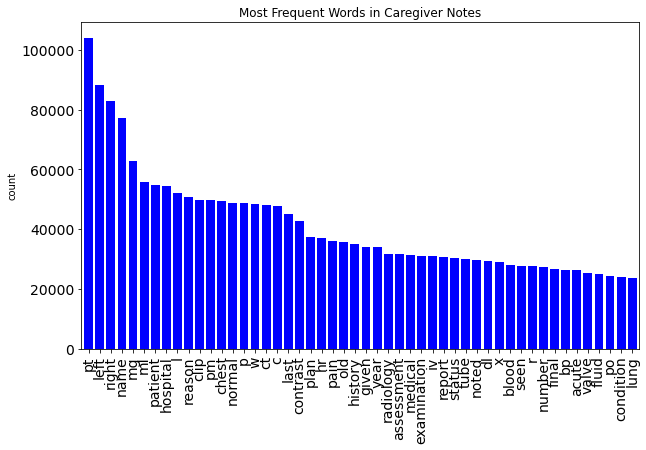

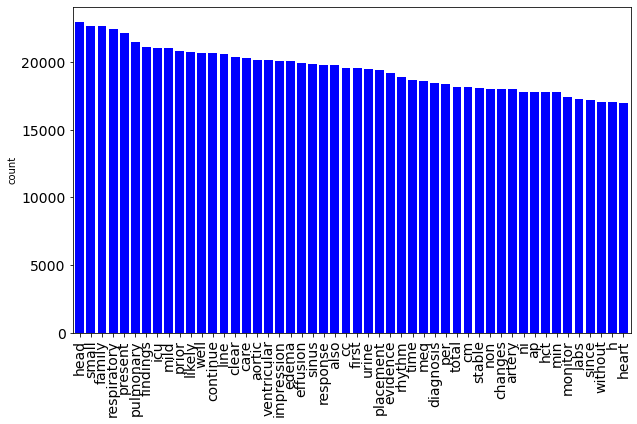

In [44]:
#Create a series from the sparse matrix
d = pd.Series(term_freq_df.total, 
              index = term_freq_df.index).sort_values(ascending=False)

#Visualize the 100 most frequent words in the text
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.title('Most Frequent Words in Caregiver Notes')
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [45]:
#with np.printoptions(threshold=np.inf):
 #   print(neg_doc_matrix)

In [46]:
stopwords_updated = list(stopwords) + ['pt', 'left', 'right', 'name','patient', 'p','w','c']


Add the list of stop words as an argument for CountVectorizer

In [47]:

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = text_tokenizer, 
                       stop_words = stopwords_updated)
# this could take a while
vect.fit(df_train_final.TEXT.values)

C:\Users\caras\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(max_features=3000,
                stop_words=['here', 'do', 'theirs', 'if', 'against', 'over',
                            'few', "you're", "didn't", 'before', 'a', 'shouldn',
                            'at', 'just', 'in', 'not', "needn't", 'herself',
                            'too', 'because', 't', 'll', 'am', 'wouldn',
                            'about', 're', 'won', 'so', 'were', 'hers', ...],
                tokenizer=<function text_tokenizer at 0x000001DF74692AF0>)

In [48]:
#Again visualize find the most frequent words.

import matplotlib.pyplot as plt

neg_doc_matrix = vect.transform(df_train_final[df_train_final.HOSPITAL_EXPIRE_FLAG == 0].TEXT)
pos_doc_matrix = vect.transform(df_train_final[df_train_final.HOSPITAL_EXPIRE_FLAG == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:20]


,negative,positive,total
mg,32253,30493,62746
ml,29634,26223,55857
hospital,25037,29564,54601
l,26880,25263,52143
reason,22579,28045,50624
clip,22431,27342,49773
pm,22824,26838,49662
chest,23819,25723,49542
normal,27751,20993,48744
ct,20908,27063,47971


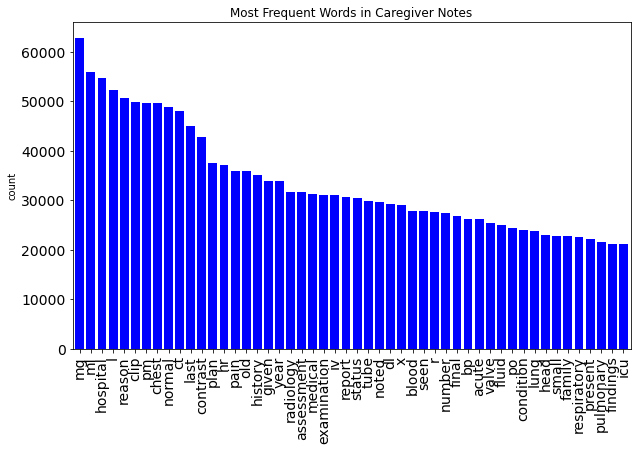

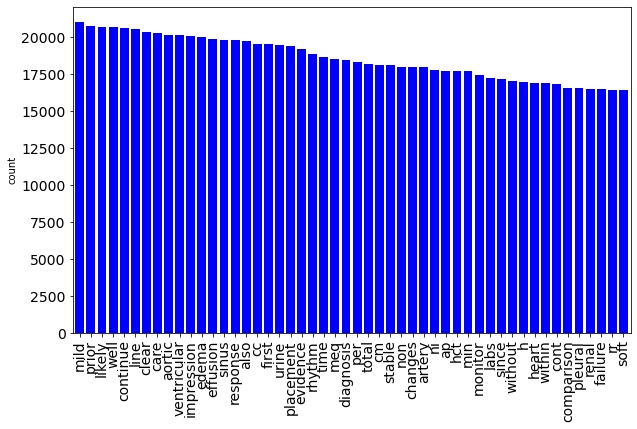

In [49]:
#Again Create a series from the sparse matrix
d = pd.Series(term_freq_df.total, 
              index = term_freq_df.index).sort_values(ascending=False)

#Visualize the 100 most frequent words in the text
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.title('Most Frequent Words in Caregiver Notes')
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

Transform the text into vectors

In [50]:
X_train_tf = vect.transform(df_train_final.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

Get labels

In [51]:
y_train = df_train_final.HOSPITAL_EXPIRE_FLAG
y_valid = df_valid.HOSPITAL_EXPIRE_FLAG

Step 3: Build a simple predictive model

In [52]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(random_state = 42, solver='lbfgs')
clf.fit(X_train_tf, y_train)

C:\Users\caras\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [53]:
#import more models for evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
#from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier(random_state=42, n_estimators=100)
knn =  KNeighborsClassifier()
svm = SVC(random_state=42, gamma='auto')
gnb = GaussianNB()
#xgboost = XGBClassifier(random_state=42)


#rf.fit(X_train_tf, y_train)


#knn.fit(X_train_tf, y_train)

#svm.fit(X_train_tf, y_train)

gnb.fit(X_train_tf.toarray(), y_train)

#xgboost.fit(X_train_tf, y_train)
#y_pred = xgboost.predict(X_test_scaled)
#print("XGBoost: ", xgboost.score(X_test_scaled, y_test))

GaussianNB()

Calculate probability of death

In [54]:
model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

In [55]:
model = gnb
y_train_preds_gnb = model.predict_proba(X_train_tf.toarray())[:,1]
y_valid_preds_gnb = model.predict_proba(X_valid_tf.toarray())[:,1]

In [56]:
#Print mortalitiy predictions for the first 10 samples in the training set
print(y_train[:10].values)
print(y_train_preds[:10])


[0 1 1 0 0 1 0 1 0 0]
[3.43283075e-01 6.45158981e-01 7.22045661e-01 5.21304202e-04
 1.65587018e-01 9.99465438e-01 8.14132622e-02 4.23555892e-01
 2.80388770e-01 5.15420344e-01]


Calculate performance metrics

In [57]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)


Logistic Regression Performance Metrics

Train AUC:0.830
Valid AUC:0.795
Train accuracy:0.743
Valid accuracy:0.706
Train recall:0.752
Valid recall:0.725
Train precision:0.739
Valid precision:0.232
Train specificity:0.735
Valid specificity:0.704
Train prevalence:0.500
Valid prevalence:0.110


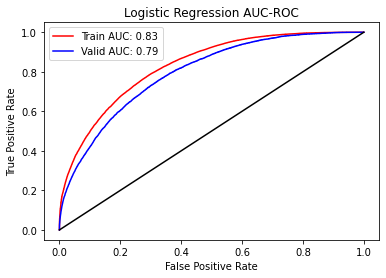

In [58]:
#LOGISTIC REGRESSION
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print("\nLogistic Regression Performance Metrics\n")
print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.title('Logistic Regression AUC-ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


Naive Bayes Performance Metrics

Train AUC:0.733
Valid AUC:0.795
Train accuracy:0.654
Valid accuracy:0.706
Train recall:0.536
Valid recall:0.725
Train precision:0.702
Valid precision:0.232
Train specificity:0.773
Valid specificity:0.704
Train prevalence:0.500
Valid prevalence:0.110


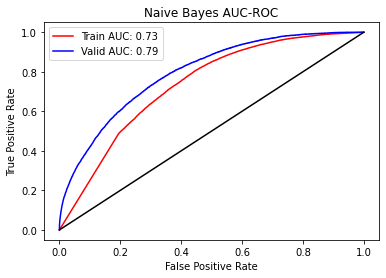

In [59]:
#GNB
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds_gnb)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds_gnb)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
print("\nNaive Bayes Performance Metrics\n")
print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds_gnb, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds_gnb, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds_gnb, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds_gnb, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.title('Naive Bayes AUC-ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Since the performance metrics results and AUC-ROC fared better with Logistic Regression, that will be the model of choice for the remainder of this project.
#### The remainder of this analysis will focus on feature engineering and hyperparameter optimization in order to create a stronger algorithm to predict mortality. 

### Feature Engineering

### Hyperparameter Tuning